In [1]:
import laspy
import matplotlib.pyplot as plt
import numpy as np
import math
from pyproj import Proj, transform, Transformer
import subprocess
import os
from datetime import datetime 


In [2]:
#snippet from Edward's code - calculate the receiver coordinates from lat, long to ECEF

#coordinates need to be added here

lat_deg =52.005319 #51.993889# # # 51.997803 #  51.999275  Latitude (degree) (user input)#####
lon_deg =4.373444 #4.378264# # #4.377388  # 4.372454 # Longitude (degree) (user input)#####

#here has to be specified that lat, long, alt is calculated related to the ellipsoid, 
#so 43.5 is added to the user input height to bring the height to the NAP height that is going to be used
rec_height= 0 #1.56   #0# this has to be changed with the height measured from the ground to the receiver
pt_height=  -1.0 # 1.0 # Altitude of the point (meter) (user input) - you change this # -1.2 # #+0.5
alt = 43.5 +pt_height+rec_height 
sealevel = 0
lat = np.radians(lat_deg)  # Latitude (rad)
lon = np.radians(lon_deg)  # Longitude (rad)

# WGS84 ellipsoid constants
a = 6378137
es = 8.1819190842622e-2

# Intermediate calculation
N = a / np.sqrt(1 - es ** 2 * np.sin(lat) ** 2)

xTgt = (N + alt) * np.cos(lat) * np.cos(lon)  # Target x ECEF coordinate (meter)
yTgt = (N + alt) * np.cos(lat) * np.sin(lon)  # Target y ECEF coordinate (meter)
zTgt = ((1 - es ** 2) * N + alt) * np.sin(lat)  # Target z ECEF coordinate (meter)

meg=Transformer.from_crs(4326, 28992, always_xy=True)
#lat_deg = 51.999275
#lon_deg = 4.372454

x_rd, y_rd=meg.transform(lon_deg,lat_deg)
z_nap=alt-43.5 #3.0
print(x_rd, y_rd)
rdnap_rec_coord=np.array([x_rd, y_rd, z_nap])

print(rdnap_rec_coord)

print(xTgt, yTgt, zTgt)
ecef_rec_coords=np.array([xTgt, yTgt, zTgt])

85392.97096867832 446813.11595006526
[ 8.53929710e+04  4.46813116e+05 -1.00000000e+00]
3923063.720963714 300034.3020900836 5003201.184464759


In [3]:
def read_ptcloud(name):
    pointcloud = laspy.read(name)
    pc = []
    for c1,c2,c3,c in zip(pointcloud['X'],pointcloud['Y'],pointcloud['Z'],pointcloud['classification']):
        x = (c1*pointcloud.header.x_scale) + pointcloud.header.x_offset
        y = (c2*pointcloud.header.y_scale) + pointcloud.header.y_offset
        z = (c3*pointcloud.header.z_scale) + pointcloud.header.z_offset
        pc.append((x,y,z,c))
     
    #print("\n","-"*10,"offsets and scales printed for hardcoding to output laz files","-"*10)
    #print("x_offset: {}\tx_scale: {}".format(pointcloud.header.x_offset,pointcloud.header.x_scale))
    #print("y_offset: {}\ty_scale: {}".format(pointcloud.header.y_offset,pointcloud.header.y_scale))
    #print("z_offset: {}\tz_scale: {}\n".format(pointcloud.header.z_offset,pointcloud.header.z_scale))
  
    points = np.array(pc)
    #print(pointcloud.header.point_format)
    return points  

def ascii_pc(ant,sat,tm):
    file_name="pc_xyz_"+str(tm)+".txt"
    with open(file_name, "w") as f1:
        f1.write("x y z\n")
        f1.write(str(float(ant[0]))+" "+str(float(ant[1]))+" "+str(float(ant[2])))
        f1.write("\n")
        for p in sat:
            f1.write(str(float(p[0]))+" "+str(float(p[1]))+" "+str(float(p[2])))
            f1.write("\n")
    

In [4]:
def utc_to_gps(utc_time):
    gps_epoch = datetime(1980, 1, 6, 0, 0, 0)  # GPS time epoch
    leap_seconds_table = [
        (datetime(1981, 7, 1), 1),
        (datetime(1982, 7, 1), 2),
        (datetime(1983, 7, 1), 3),
        (datetime(1985, 7, 1), 4),
        (datetime(1988, 1, 1), 5),
        (datetime(1990, 1, 1), 6),
        (datetime(1991, 1, 1), 7),
        (datetime(1992, 7, 1), 8),
        (datetime(1993, 7, 1), 9),
        (datetime(1994, 7, 1), 10),
        (datetime(1996, 1, 1), 11),
        (datetime(1997, 7, 1), 12),
        (datetime(1999, 1, 1), 13),
        (datetime(2006, 1, 1), 14),
        (datetime(2009, 1, 1), 15),
        (datetime(2012, 7, 1), 16),
        (datetime(2015, 7, 1), 17),
        (datetime(2017, 1, 1), 18),
     ]   
               

    leap_seconds = 0
    for leap_date, leap_seconds_offset in leap_seconds_table:
        if utc_time >= leap_date:
            leap_seconds = leap_seconds_offset

    delta_time = utc_time - gps_epoch
    total_seconds = delta_time.total_seconds() + leap_seconds
    gps_week = total_seconds // 604800
    gps_seconds = total_seconds % 604800
    
    return int(gps_week), int(gps_seconds)

In [5]:
def compute_time(mo,d,h,mi,data,s):
    wn=data[0]
    toa=data[1]
    utc_time = datetime(2023, mo, d, h, mi, s)
    gps_week, gps_second = utc_to_gps(utc_time)
    #print(gps_week, gps_second)
    while(gps_week>=1024):
        gps_week-=1024
        #print(gps_week)
    tk = (gps_week - wn) * 604800 + (gps_second - toa)
    #print("gpsweek-wn:",gps_week - wn)
    #print("gpssec-toa:",gps_second - toa)
    #print(wn, toa)
    return tk


In [6]:
with open('D:/irina/Rezumate/delft/thesis/test script/help_code/dop_fromev/current_sem_1812.txt', 'r') as f:
    NumSV = int(f.readline().strip().split()[0]) # Number of Satellites
#    name = f.readline().strip()
#    data = np.array([float(x) for x in f.readline().strip().split()])

    
    # Read the rest of the data
    data_list = []
    for line in f:
        line = line.strip()
        if line:  # Skip empty lines
            for element in line.split():
                data_list.append(element)

    # Convert the data into a NumPy array if needed
    alm_data = np.array(data_list, dtype=float)

#print(alm_data)
wn=alm_data[0]
toa=alm_data[1]
# print("wn0:", wn, "toa0:", toa)
# utc_time = datetime(2023, 11, 21, 9, 33, 0)
# gps_week, gps_second = utc_to_gps(utc_time)
# print(gps_week, gps_second)
        
#         # Print the results
#         #print("GPS Week:", gps_week)
#         #print("GPS Second:", gps_second)
        
# Total_weeks = gps_week  # Total number of weeks since 6 Jan 1980
# #print(gps_week)
# while gps_week >= 1024:
#     gps_week -= 1024
        
# tk = (gps_week - wn) * 604800 + (gps_second - toa)  # Time since toa (sec) (range: -302,400 to 302,400)
# print("gps_week - wn:",gps_week - wn)
# print("gps_second - toa:",gps_second - toa)
# print(tk)
# tk1=compute_time(11, 21, 9, 33,alm_data)
# print(tk1)

In [7]:
def ECEF_coords(data,num,tk):
    # Constants
    io = 0.3 * np.pi  # Inclination angle @ ref. time (rad)
    mju = 3.986005e14  # WGS 84 value of the Earth's universal gravitational parameter for GPS user (meters^3/sec^2)
    OMEGAdote = 7.2921151467e-5  # WGS 84 value of the Earth's rotation rate (rad/sec)
    PRN = data[num + 3]  # PRN number
    #SVN = data[num + 4]  # Satellite number
    #URA = data[num + 5]  # Average URA number
    ec = data[num + 6]  # Eccentricity (dimensionless) (range: 0-0.03)
    del_ik = data[num + 7] * np.pi  # Inclination correction (rad)
    OMEGAdot = data[num + 8] * np.pi  # Rate of right ascension (rad/sec)
    sqrtA = data[num + 9]  # Sqr root semi-major axis (m^1/2)
    OMEGAo = data[num + 10] * np.pi  # Right ascension @ ref. time (rad)
    omega = data[num + 11] * np.pi  # Argument of perigee (rad)
    Mo = data[num + 12] * np.pi  # Mean Anomaly @ ref. time (rad)
    #print ('data12',data[num + 12])
    #Af0 = data[num + 13]  # Clock offset (sec)
    #Af1 = data[num + 14]  # Clock drift (sec/sec)
    #Health = data[num + 15]  # Satellite Health; 0=healthy
    
    #tk=compute_time(h,m,wn,toa)
    # Calculations
    A = sqrtA ** 2  # Orbit semi-major axis (meter)
    n = np.sqrt(mju / (A ** 3))  # Computed mean motion (rad/sec)
    Mk = Mo + tk * n  # Mean anomaly (rad)
        
    # Start values for iterative solution of Kepler eq.
    Ek = Mk
    Eold = 0
    while np.abs(Ek - Eold) >= 1.0e-10:
        Eold = Ek
        Ek = Mk + ec * np.sin(Ek)
    # End of iteration
        
    vk = np.arctan2((np.sqrt(1 - ec ** 2) * np.sin(Ek)) / (1 - ec * np.cos(Ek)), (np.cos(Ek) - ec) / (1 - ec * np.cos(Ek)))
    # True anomaly (rad)
    Ek = np.arccos((ec + np.cos(vk)) / (1 + ec * np.cos(vk)))
    uk = omega + vk  # Argument of latitude (rad)
    rk = A * (1 - ec * np.cos(Ek))  # Corrected radius (meter)
    ik = io + del_ik  # Corrected inclination (rad)
    xk1 = rk * np.cos(uk)  # x position in orbital plane (meter)
    yk1 = rk * np.sin(uk)  # y position in orbital plane (meter)
    OMEGAk = OMEGAo + (OMEGAdot - OMEGAdote) * tk - OMEGAdote * (toa)
    # Corrected longitude of ascending node (rad)
    xk=xk1 * np.cos(OMEGAk) - yk1 * np.cos(ik) * np.sin(OMEGAk)
    yk=xk1 * np.sin(OMEGAk) + yk1 * np.cos(ik) * np.cos(OMEGAk)
    zk=yk1 * np.sin(ik)

    # dX=xk-ant_ecef[0]
    # dY=yk-ant_ecef[1]
    # dZ=zk-ant_ecef[2]

    # mag_ant=math.sqrt(ant_ecef[0]**2+ant_ecef[1]**2+ant_ecef[2]**2)
    # mag_ant_sat=math.sqrt(dX**2+dY**2+dZ**2)
    # print(xk*ant_ecef[0]+yk*ant_ecef[1]+zk*ant_ecef[2])
    # print(mag_ant*mag_ant_sat)
    # angle=math.acos((xk*ant_ecef[0]+yk*ant_ecef[1]+zk*ant_ecef[2])/(mag_ant*mag_ant_sat))

    return PRN, xk, yk, zk
    

    

In [8]:
def ECEF_obstruction(ant_ecef, sat_ecef, obs):
    dX=sat_ecef[0]-ant_ecef[0]
    dY=sat_ecef[1]-ant_ecef[1]
    dZ=sat_ecef[2]-ant_ecef[2]

    mag_ant=math.sqrt(ant_ecef[0]**2+ant_ecef[1]**2+ant_ecef[2]**2)
    mag_ant_sat=math.sqrt(dX**2+dY**2+dZ**2)
    #print(sat_ecef[0]*ant_ecef[0]+sat_ecef[1]*ant_ecef[1]+sat_ecef[2]*ant_ecef[2])
    #print(mag_ant*mag_ant_sat)
    angle=np.arccos((sat_ecef[0]*ant_ecef[0]+sat_ecef[1]*ant_ecef[1]+sat_ecef[2]*ant_ecef[2])/(mag_ant*mag_ant_sat))
    los=0
    
    if((angle*180/math.pi)<(90-(obs*180/math.pi))):
        los=1
    else:
        los=0

    return los
    

In [9]:
def new_pt(p1, p2, no):
    #this function creates a new point which is "no" meters in 3d space from the 1st point
    dir=p2-p1
    dir_mag=math.sqrt(dir[0]**2+dir[1]**2+dir[2]**2)
    udir=dir/dir_mag
    npt=p1+no*udir
    #npt[2]=npt[2]+34

    return npt

In [10]:
main_cmd="+proj=pipeline " #introduce pipeline
tf1="+step +proj=noop +inv " #inverse 8
tf2="+step +proj=cart +ellps=GRS80 +inv " #inverse 4
tf3="+step +proj=vgridshift +grids=./nl_nsgi_nlgeo2018.tif " #5
tf4="+step +proj=hgridshift +grids=./nl_nsgi_rdtrans2018.tif +inv " #inverse 6
tf_opt="+step +proj=helmert +x=0 +y=0 +z=43 +rx=0 +ry=0 +rz=0 +s=0 " #height difference between ECEF and RDNAP is 43 m, maybe this step is needed
tf5="+step +proj=sterea +lat_0=52.156160556 +lon_0=5.387638889 +k=0.9999079 +x_0=155000 +y_0=463000 +ellps=bessel "
ih=Transformer.from_pipeline(main_cmd+tf1+tf2+tf3+tf4+tf5)

main_cmd="+proj=pipeline " #introduce pipeline
tf1_inv="+step +proj=noop " #8
tf2_inv="+step +proj=cart +ellps=GRS80 " #4
tf3_inv="+step +proj=vgridshift +grids=./nl_nsgi_nlgeo2018.tif +inv " #inverse 5
tf4_inv="+step +proj=hgridshift +grids=./nl_nsgi_rdtrans2018.tif " #6
tf5_inv="+step +proj=sterea +lat_0=52.156160556 +lon_0=5.387638889 +k=0.9999079 +x_0=155000 +y_0=463000 +ellps=bessel +inv " #inverse 7
ih_inv=Transformer.from_pipeline(main_cmd+tf5_inv+tf4_inv+tf3_inv+tf2_inv+tf1_inv)

op=Transformer.from_crs(28992, 4326, always_xy=True)



In [11]:
def midpoint(p1,p2):
    midpoint=np.array([(p1[0]+p2[0])/2,(p1[1]+p2[1])/2])

    return midpoint

def dir_bbox(p1,p2):
    xdif=p2[0]-p1[0]
    ydif=p2[1]-p1[1]

    if(xdif>0 and ydif>0):
      #print('1stquarter')
      minx=p1[0]
      miny=p1[1]
      maxx=p2[0]
      maxy=p2[1]
      #return p1,p2
      bbox=[(maxx, maxy), (minx,maxy), (minx, miny), (maxx, miny), (maxx, maxy)]
    elif(xdif>0 and ydif<0):
      #print('2ndquarter')
      minx=p1[0]
      miny=p2[1]
      maxx=p2[0]
      maxy=p1[1]
      bbox=[(maxx, miny), (maxx, maxy), (minx,maxy), (minx, miny), (maxx, miny)]
    elif(xdif<0 and ydif<0):
      #print('3rdquarter')
      minx=p2[0]
      miny=p2[1]
      maxx=p1[0]
      maxy=p1[1]
      bbox=[(minx, miny), (maxx, miny), (maxx, maxy), (minx,maxy), (minx, miny)]
    else:
      #print('4thquarter')
      minx=p2[0]
      miny=p1[1]
      maxx=p1[0]
      maxy=p2[1]
      bbox=[(minx,maxy), (minx, miny), (maxx, miny), (maxx, maxy), (minx,maxy)]

    #bbox=[(minx, miny), (maxx, miny), (maxx, maxy), (minx,maxy), (minx, miny)]
    return bbox

def segment(p1,p2,eps,bblist):
    dist=math.sqrt((p2[0]-p1[0])**2+(p2[1]-p1[1])**2)
    bb=[]
    if(dist<eps):
        bb=dir_bbox(p1,p2)
        #print(bb)
        bblist.append(bb)
        
    else:
        midpt=midpoint(p1,p2)
        line1=[p1,midpt]
        line2=[midpt,p2]

        segment(p1,midpt,eps,bblist)
        segment(midpt,p2,eps,bblist)

def two_small_boxes(p,l,endpt):
    #declare the other 3 points of the 1st box
    p1=np.array([0,0])
    p2=np.array([0,0])
    p3=np.array([0,0])
    #declare the other 3 points of the 2nd box 
    p4=np.array([0,0])
    p5=np.array([0,0])
    p6=np.array([0,0])

    xdif=endpt[0]-p[0]
    ydif=endpt[1]-p[1]

    if((xdif>0 and ydif>0) or (xdif<0 and ydif<0)):
        p1[0],p1[1]=p[0],p[1]+l
        p2[0],p2[1]=p[0]-l,p[1]+l
        p3[0],p3[1]=p[0]-l,p[1]
        p4[0],p4[1]=p[0]+l,p[1]
        p5[0],p5[1]=p[0]+l,p[1]-l
        p6[0],p6[1]=p[0],p[1]-l
    elif((xdif>0 and ydif<0) or (xdif<0 and ydif>0)):
        p1[0],p1[1]=p[0]-l,p[1]
        p2[0],p2[1]=p[0]-l,p[1]-l
        p3[0],p3[1]=p[0],p[1]-l
        p4[0],p4[1]=p[0],p[1]+l
        p5[0],p5[1]=p[0]+l,p[1]+l
        p6[0],p6[1]=p[0]+l,p[1]


    

    sbox1=[np.array([float(p[0]),float(p[1])]),np.array([float(p1[0]),float(p1[1])]),np.array([float(p2[0]),float(p2[1])]),np.array([float(p3[0]),float(p3[1])])]
    sbox2=[np.array([float(p[0]),float(p[1])]),np.array([float(p4[0]),float(p4[1])]),np.array([float(p5[0]),float(p5[1])]),np.array([float(p6[0]),float(p6[1])])]

    minx1=1000000000000
    maxx1=-10000
    miny1=1000000000000
    maxy1=-10000
    minx2=1000000000000
    maxx2=-10000
    miny2=1000000000000
    maxy2=-10000

    for i in sbox1:
        if(i[0]>maxx1):
            maxx1=i[0]
        elif(i[0]<minx1):
            minx1=i[0]

        if(i[1]>maxy1):
            maxy1=i[1]
        elif(i[1]<miny1):
            miny1=i[1]

    for j in sbox2:
        if(j[0]>maxx2):
            maxx2=j[0]
        elif(j[0]<minx2):
            minx2=j[0]

        if(j[1]>maxy2):
            maxy2=j[1]
        elif(j[1]<miny2):
            miny2=j[1]
    sbox11=[(minx1,miny1),(minx1,maxy1),(maxx1,maxy1),(maxx1,miny1),(minx1,miny1)]
    sbox12=[(minx2,miny2),(minx2,maxy2),(maxx2,maxy2),(maxx2,miny2),(minx2,miny2)]
    return sbox11, sbox12

def borders(bbox):
    xmin=10000000
    ymin=10000000
    xmax=-10000
    ymax=-10000

    for j in bbox:
        if(j[0]>=xmax):
            xmax=j[0]
        if(j[0]<=xmin):
            xmin=j[0]
        if(j[1]>=ymax):
            ymax=j[1]
        if(j[1]<=ymin):
            ymin=j[1]

    return xmin, ymin, xmax, ymax




In [12]:
def wkt_bbox(bb):
    str0='POLYGON(('
    
    for i in range(0,len(bb)-1):
        str0=str0+str(bb[i][0])+" "+str(bb[i][1])+","
    
    
    str0=str0+str(bb[len(bb)-1][0])+" "+str(bb[len(bb)-1][1])+'))'
    return str0

def wkt_sat(rdnap_sat,antenna_rd,tm):
    file_name="pointstoadd_"+str(tm)+".txt"
    with open(file_name, "w") as f1:
        f1.write("geometry\n")
        f1.write("POINT Z ("+str(float(antenna_rd[0]))+" "+str(float(antenna_rd[1]))+" "+str(float(antenna_rd[2]))+")")
        f1.write("\n")
        for p in rdnap_sat:
            f1.write("POINT Z ("+str(float(p[0]))+" "+str(float(p[1]))+" "+str(float(p[2]))+")")
            f1.write("\n")

def wkt_cyl_ax(rdnap_sat,antenna_rd,tm):
    file_name="rd_linestring_"+str(tm)+".txt"
    with open(file_name, "w") as f:
        f.write("geometry\n")
        for p in rdnap_sat:
            f.write("LINESTRING ("+str(antenna_rd[0])+" "+str(antenna_rd[1])+" "+str(antenna_rd[2])+","+str(p[0])+" "+str(p[1])+" "+str(p[2])+")")
            f.write("\n")

In [13]:
def filter_pointcloud(bblist,sat,linepts,eps2,sat_no,tm,ant_rd):
    #in com_string1, the name of the point cloud needs to be changed
    com_string1="D:/programs/LAStools/LAStools/bin/las2las -i D:/irina/Rezumate/delft/thesis/P3/data/height1_filter.LAZ -inside_rectangle "
    com_string2=" -o D:/irina/Rezumate/delft/thesis/P3/data/pc_bits/"+str(sat_no+tm)
    com_string2_alt=" -o D:/irina/Rezumate/delft/thesis/P3/data/pc/pc"+str(sat_no+tm)
    ext_str=".LAZ"
    if(abs(ant_rd[0]-sat[0])<10):
        pc_name=str(sat_no)
        b_alt1=ant_rd[0]+eps2
        b_alt2=ant_rd[0]-eps2
        if(ant_rd[1]>sat[1]):
            ymin=sat[1]
            ymax=ant_rd[1]
        else:
            ymin=ant_rd[1]
            ymax=sat[1]
        coord_str=str(b_alt2)+" "+str(ymin)+" "+str(b_alt1)+" "+str(ymax)
        cmd_string_a=com_string1+coord_str+com_string2_alt+ext_str
        #print(cmd_string_a)
        subprocess.call(cmd_string_a.split())
    elif(abs(ant_rd[1]-sat[1])<10):
        pc_name=str(sat_no)
        b_alt1=ant_rd[1]+eps2
        b_alt2=ant_rd[1]-eps2
        if(ant_rd[0]>sat[0]):
            xmin=sat[0]
            xmax=ant_rd[0]
        else:
            xmin=ant_rd[0]
            xmax=sat[0]
        coord_str=str(xmin)+" "+str(b_alt2)+" "+str(xmax)+" "+str(b_alt1)
        cmd_string_b=com_string1+coord_str+com_string2_alt+ext_str
        #print(cmd_string_b)
        subprocess.call(cmd_string_b.split())

        #com_string_a="mkdir D:/irina/Rezumate/delft/thesis/P3/data/pc_bits/"+str(sat_no)
        #subprocess.call(com_string_a.split())
    else:

        for no in range(0,len(bblist)-1):
            x1, y1, x2, y2=borders(bblist[no])
            coord_str=str(x1)+" "+str(y1)+" "+str(x2)+" "+str(y2)
            pc_str=str(no)
            cmd_string=com_string1+coord_str+com_string2+pc_str+ext_str
            subprocess.call(cmd_string.split())

        ct=0
        sbb1_ar=[]
        sbb2_ar=[]
        for p in linepts:
            sbb1,sbb2=two_small_boxes(p,eps2,sat)
            x11, y11, x12, y12=borders(sbb1)
            x21, y21, x22, y22=borders(sbb2)
            sbb1_ar.append(sbb1)
            sbb2_ar.append(sbb2)
            coordstr1=str(x11)+" "+str(y11)+" "+str(x12)+" "+str(y12)
            coordstr2=str(x21)+" "+str(y21)+" "+str(x22)+" "+str(y22)
            pc_str1=str(ct)+"a"
            pc_str2=str(ct)+"b"
            cmd_str1=com_string1+coordstr1+com_string2+pc_str1+ext_str
            cmd_str2=com_string1+coordstr2+com_string2+pc_str2+ext_str
            subprocess.call(cmd_str1.split())
            subprocess.call(cmd_str2.split())
            ct=ct+1
        
        txtfnma="bbox_wkt "+str(sat_no)+"a"+".txt"
        with open(txtfnma,"w") as fl1:
                fl1.write("geometry")
                fl1.write("\n")
                for sb in sbb1_ar:
                    string=wkt_bbox(sb)
                    fl1.write(string)
                    fl1.write('\n')
        fl1.close()

        txtfnmb="bbox_wkt "+str(sat_no)+"b"+".txt"
        with open(txtfnmb,"w") as fl2:
                fl2.write("geometry")
                fl2.write("\n")
                for sb in sbb2_ar:     
                    string=wkt_bbox(sb)
                    fl2.write(string)
                    fl2.write('\n')
        fl2.close()






        
        
        com_string_final="D:/programs/LAStools/LAStools/bin/lasmerge -i D:/irina/Rezumate/delft/thesis/P3/data/pc_bits/*.LAZ"+" -o D:/irina/Rezumate/delft/thesis/P3/data/pc/pc"+str(sat_no+tm)+".LAZ"
        subprocess.call(com_string_final.split())
    
        for fl in os.listdir('D:/irina/Rezumate/delft/thesis/P3/data/pc_bits'):
            if os.path.isfile(os.path.join('D:/irina/Rezumate/delft/thesis/P3/data/pc_bits', fl)):
                os.remove(os.path.join('D:/irina/Rezumate/delft/thesis/P3/data/pc_bits', fl))

    

In [14]:
def algorithm_2d(ant,sat,eps1,eps2,sat_no,tm):
    bblist=[]
    linepts=[]
    
    #for sat in sat_list:
    bblist.append(segment(ant,sat,eps1,bblist))
    for bbno in range(0,len(bblist)-2):
        linepts.append(bblist[bbno][0])

    filter_pointcloud(bblist,sat,linepts,eps2,sat_no,tm,ant)
    
    txtfnm="bbox_wkt "+str(sat_no)+".txt"
    with open(txtfnm,"w") as fl:
        fl.write("geometry")
        fl.write("\n")
        for i in range(0,len(bblist)-1):
            string=wkt_bbox(bblist[i])
            fl.write(string)
            fl.write('\n')
    fl.close()
        

    
            
    

#print(bblist)

In [15]:
#code from https://www.flipcode.com/archives/Fast_Point-In-Cylinder_Test.shtml
def points_in_cylinder(pt1, pt2, r, q):
    #if(q[2]>pt1[2]):
        dx=pt2[0]-pt1[0]
        dy=pt2[1]-pt1[1]
        dz=pt2[2]-pt1[2]
        lgt=math.sqrt((pt2[0]-pt1[0])**2+(pt2[1]-pt1[1])**2+(pt2[2]-pt1[2])**2)
        tdx=q[0]-pt1[0]
        tdy=q[1]-pt1[1]
        tdz=q[2]-pt1[2]

        dprod=tdx*dx+tdy*dy+tdz*dz
        if(dprod<0 or dprod>lgt**2):
            return 0
        else:
            dsq=tdx**2+tdy**2+tdz**2-(dprod*dprod)/lgt**2
            if(dsq>r*r):
                return 0
            else:
                return 1
            

            

def algorithm_3d(rec, sat, r, pt_list):
    no=0
    distrib=[]
    for pt in pt_list:
        a=points_in_cylinder(rec, sat, r, pt)
        if(a==1):
            no=no+1
            distrib.append([pt[0],pt[1],pt[2],pt[3]])
    return no,distrib

def distribution_analysis(pt_list,r_circ):
     avg_x=0
     avg_y=0
     avg_z=0
     nopts=0
     for i in pt_list:
          avg_x=i[0]+avg_x
          avg_y=i[1]+avg_y
          avg_z=i[2]+avg_z
     
     avg_x=avg_x/len(pt_list)
     avg_y=avg_y/len(pt_list)
     avg_z=avg_z/len(pt_list)

     for i in pt_list:
          d=math.sqrt((i[0]-avg_x)**2+(i[1]-avg_y)**2+(i[2]-avg_z)**2)
          if(d<r_circ):
               nopts=nopts+1
     return nopts

def cyl_to_pc(distribution, sat_no,tm,name_pc):
    init_pc=laspy.read(name_pc)
    outfl=laspy.create(point_format=init_pc.header.point_format)
    xd=[d[0] for d in distribution]
    yd=[d[1] for d in distribution]
    zd=[d[2] for d in distribution]
    classif=[d[3] for d in distribution]
    outfl.header=init_pc.header
    outfl.header.x_offset=init_pc.header.x_offset
    outfl.header.y_offset=init_pc.header.y_offset
    outfl.header.z_offset=init_pc.header.z_offset
    outfl.header.x_scale=init_pc.header.x_scale
    outfl.header.y_scale=init_pc.header.y_scale
    outfl.header.z_scale=init_pc.header.z_scale
    outfl.x=xd
    outfl.y=yd
    outfl.z=zd
    # points=[pt[:3] for pt in distribution]
    # classif=[pt[3] for pt in distribution]
    # outfl.points=points
    outfl.classification=classif
    # for dis in distribution:
    #     outfl.points.append(dis[:2])
    #     outfl.classification.append(dis[3])
    outfl.write("D:/irina/Rezumate/delft/thesis/P3/data/cylinder/cylinder_"+str(sat_no+tm)+".LAZ")

def class_analysis(cyl_pc):
    cyl_pts=read_ptcloud(cyl_pc)
    cls_ar=[]
    no_pts_cls=np.zeros(len(cls_ar))
    proc_cls=[]

    for p in cyl_pts:
        for j in cls_ar:
            if(j!=p[3]):
                cls_ar.append(p[3])

    
    for c in cls_ar:
        no=0
        for p in cyl_pts:
            if(p[3]==c):
                no=no+1
        no_pts_cls.append(no)

    for i in no_pts_cls:
        pr=(i/len(cyl_pts))*100
        proc_cls.append(pr)

    return cls_ar, proc_cls



def elev(a,b):
    d=math.sqrt((b[1]-a[1])**2+(b[0]-a[0])**2)
    hgt=b[2]-a[2]
    el=math.atan(hgt/d)*180/math.pi
    return el

def azimuth(ant_enu, sat_enu):
    dE=sat_enu[0]-ant_enu[0]
    dN=sat_enu[1]-ant_enu[1]
    azim=math.atan(dE/dN)*180/math.pi
    if(dE<0 and dN<0):
        azim=azim+180
    elif(dE<0 and dN>0):
        azim=azim+360
    elif(dE>0 and dN<0):
        azim=azim+180
    elif(dE>0 and dN>0):
        azim=azim+0

    return azim
               
     


In [16]:
def ecef_to_ENU(ant_rd, sat):
    
    lon, lat=op.transform(ant_rd[0], ant_rd[1])
    lon_rad, lat_rad=np.radians(lon), np.radians(lat)
    #print(lon, lat)
    
    #constants
    sealevel=0
    a = 6378137
    es = 8.1819190842622e-2
    N = a / np.sqrt(1 - es ** 2 * np.sin(lat_rad) ** 2)

    #antenna coords in ECEF

    xTgt = (N + ant_rd[2]) * np.cos(lat_rad) * np.cos(lon_rad)  # Target x ECEF coordinate (meter)
    yTgt = (N + ant_rd[2]) * np.cos(lat_rad) * np.sin(lon_rad)  # Target y ECEF coordinate (meter)
    zTgt = ((1 - es ** 2) * N + ant_rd[2]) * np.sin(lat_rad)  # Target z ECEF coordinate (meter)

    antenna_ENU=np.array([xTgt, yTgt, zTgt])

    xLocalRef = (N + sealevel) * np.cos(lat_rad) * np.cos(lon_rad)  # ENU Local ref pt x ECEF coordinate (meter)
    yLocalRef = (N + sealevel) * np.cos(lat_rad) * np.sin(lon_rad)  # ENU Local ref pt y ECEF coordinate (meter)
    zLocalRef = ((1 - es ** 2) * N + sealevel) * np.sin(lat_rad)  # ENU Local ref pt z ECEF coordinate (meter)

    East = -np.sin(lon_rad) * (sat[0] - xLocalRef) + np.cos(lon_rad) * (sat[1] - yLocalRef)
    North = -np.sin(lat_rad) * np.cos(lon_rad) * (sat[0] - xLocalRef) - np.sin(lat_rad) * np.sin(lon_rad) * (sat[1] - yLocalRef) + np.cos(lat_rad) * (sat[2] - zLocalRef)
    Up = np.cos(lat_rad) * np.cos(lon_rad) * (sat[0] - xLocalRef) + np.cos(lat_rad) * np.sin(lon_rad) * (sat[1] - yLocalRef) + np.sin(lat_rad) * (sat[2] - zLocalRef)

    ENU_sat=np.array([East, North, Up])

    return antenna_ENU, ENU_sat

In [17]:
def calculate_DoP(sat_list,antenna):
    noval=len(sat_list)
    r = np.empty(noval)
    Dx = np.empty(noval)
    Dy = np.empty(noval)
    Dz = np.empty(noval)
    Dt = np.empty(noval)
        
    for num4 in range(noval):
        # Calculate pseudo-ranges from receiver position to other vehicles
        r[num4] = np.sqrt(sat_list[num4][0] ** 2 + sat_list[num4][1] ** 2 + (sat_list[num4][2] - antenna[2]) ** 2)
        # Calculate directional derivatives for X, Y, Z, and Time
        Dx[num4] = (sat_list[num4][0] - 0) / r[num4]  # x-coordinates of Tgt in ENU frame is zero
        Dy[num4] = (sat_list[num4][1] - 0) / r[num4]  # y-coordinates of Tgt in ENU frame is zero
        Dz[num4] = (sat_list[num4][2] - antenna[2]) / r[num4]  # z-coordinates of Tgt in ENU frame is the altitude
        Dt[num4] = -1
        
    # Produce the Covariance Matrix from the Directional Derivatives
    Alp = np.column_stack((Dx, Dy, Dz, Dt))
    Brv = Alp.T
    Chl = np.dot(Brv, Alp)
    Dlt = np.linalg.inv(Chl)
    #print(Dlt)
        
    # Calculate DOPs from the diagonal elements of the Covariance Matrix
    GDOP = np.sqrt(Dlt[0, 0] + Dlt[1, 1] + Dlt[2, 2] + Dlt[3, 3])
    PDOP = np.sqrt(Dlt[0, 0] + Dlt[1, 1] + Dlt[2, 2])
    HDOP = np.sqrt(Dlt[0, 0] + Dlt[1, 1])
    TDOP = np.sqrt(Dlt[3, 3])
    VDOP = np.sqrt(Dlt[2, 2])
    YDOP = np.sqrt(Dlt[1, 1])
    XDOP = np.sqrt(Dlt[0, 0])

    return GDOP, PDOP, HDOP, TDOP, VDOP

In [19]:
#antenna_ecef=np.array([3923598.301854494, 300006.99525426026, 5002788.431322614])
#antenna_rdnap=np.array([85315.60488322857, 446141.6694703116, 0.6])
#prn_list_test=[5.0,11.0,30.0,4.0,9.0,29.0,20.0,7.0,16.0,6.0,13.0,26.0]
antenna_ecef=ecef_rec_coords
print(ecef_rec_coords)
antenna_rdnap=rdnap_rec_coord
#print(antenna_rdnap)
plot_count=[]
distrib_satellites=[]
plot_time=0 # minutes of the day
sat_no=0
GDOP_val=[]
PDOP_val=[]
HDOP_val=[]
TDOP_val=[]
VDOP_val=[]
DOP_vals=[]
#sat_prn_above=[]
#sat_prn_visib=[]
time_ct=0 # this one is a counting variable for the moment of time
prn_angles_tot=[]
ct1=1
for h in range(15,16):
    visib_sat=[]
    for mi in range(2,15,3):
        s=0
        tk=compute_time(12,18,h,mi,alm_data,s)
        #print(tk)
        print(h,mi,s)
        ecef_pts=[]
        ecef_above=[]
        ecef_for_enu=[]
        rdnap_pts=[]
        k=-1
        sat_prn=[]
        sat_prn_above=[]
        while(k<(len(alm_data)-14)):
            prn, x_ecef, y_ecef, z_ecef=ECEF_coords(alm_data,k,tk)
            
            sat_ecef=np.array([x_ecef,y_ecef,z_ecef])
            #print(sat_ecef)
            ob=0
            #if(ECEF_obstruction(antenna_ecef,sat_ecef,ob)==1):
            # for i in prn_list_test:
            #     if(i==float(prn)):
            ecef_pts.append(sat_ecef)
            sat_prn.append(prn)
            
            #ecef_pts.append(np.array([x_ecef, y_ecef, z_ecef]))
            #print(x_ecef, y_ecef, z_ecef)
            k=k+14
        print(len(ecef_pts))
        for pt,name in zip(ecef_pts,sat_prn):
            new_point=new_pt(antenna_ecef,pt,500)
            #print(new_point)
            x_tf,y_tf,z_tf=ih.transform(new_point[0],new_point[1],new_point[2])
            #print("rdnap coordinates:",name,x_tf,y_tf,z_tf)
            #x_RD,y_RD,z_RD=x_tf+43.5, y_tf+43.5, z_tf+43.5
            #print(name,x_tf, y_tf, z_tf)
            if(z_tf>antenna_rdnap[2]):
                rdnap_pts.append(np.array([x_tf,y_tf,z_tf]))
                sat_prn_above.append(name)
                ecef_above.append(pt)
                #print(name,x_tf,y_tf,z_tf)
                
                #print(name,new_point)
        
        wkt_sat(rdnap_pts, antenna_rdnap,time_ct)
        wkt_cyl_ax(rdnap_pts, antenna_rdnap,time_ct)
        ascii_pc(antenna_rdnap,rdnap_pts,time_ct)
        print(len(rdnap_pts),len(ecef_above))
        elev_ang=[]
        eps1=220 # length of the main diagonal for the rectangle bboxes
        eps2=7 # length of the edge for the square boxes
        
        obstr_limit=15000
        obj_pts_no=obstr_limit/2
        r=eps2*math.sqrt(2)
        eps3=eps2 # length of straight rectangle width or length
        rad_circ=r/2
        visib_sat_pos=[]
        pos=0
        visib_sat_ecef=[]
        distribution_sat=[]
        rdnap_plot=[]
        #ct1=1
        for pt,nm,ec in zip(rdnap_pts,sat_prn_above,ecef_above):
            az0=azimuth(antenna_rdnap,pt)
            el=elev(antenna_rdnap,pt)
            elev_ang.append(el)
            print("elevation of -satellite-:",nm,el,az0)
            algorithm_2d(antenna_rdnap,pt,eps1,eps2,nm,time_ct)
            #print(nm)
            name="D:/irina/Rezumate/delft/thesis/P3/data/pc/pc"+str(nm+time_ct)+".LAZ"
            points=read_ptcloud(name)
            num,distribution=algorithm_3d(antenna_rdnap,pt,r,points)
            cyl_to_pc(distribution,nm,time_ct,name)
            distribution_sat.append(distribution)
            #print(num)
            pts_num=0
            if(num<obstr_limit and len(distribution)>100):
                #distribution_sat.append(distribution)
                #visib_sat.append(pt)
                #r1=int(r/2)
                #pts_num,axis_pts=algorithm_3d(antenna_rdnap,pt,r1,distribution)
                #pts_num=distribution_analysis(distribution,rad_circ)
                visib_sat_pos.append([nm,pt])
                #print(ecef_above[pos])
                ecef_for_enu.append(ecef_above[pos])
                rdnap_plot.append(pt)
                #if(pts_num<obj_pts_no):
             
                    
            if(len(distribution)<100):
                #distribution_sat.append(distribution)
                visib_sat_pos.append([nm,pt])
                #print(ecef_above[pos])
                ecef_for_enu.append(ecef_above[pos])
                rdnap_plot.append(pt)

            pos=pos+1
            sat_no=sat_no+1
            print(nm,num)
        wkt_sat(rdnap_plot, antenna_rdnap,ct1)
        wkt_cyl_ax(rdnap_plot, antenna_rdnap,ct1)
        prn_angles=[]
        #print(len(pos_sat))
        # sat_prn_visib=[]
        # for i,j in zip(visib_sat_pos,ecef_for_enu):
        #     print(i[0],j)
        #     for position in pos_sat:
        #         if(i==position):
        #             print(i)
        #             visib_sat_ecef.append(ecef_pts_conv[i])
        #             sat_prn_visib.append(sat_prn_above[i])
                    
            #print(i)
        angles=[]
        print("elev_ang:", len(elev_ang))
        cou=0
        for sat in ecef_above:
            antenna_ENU, sat_enu=ecef_to_ENU(antenna_rdnap,sat)
            el=elev(antenna_ENU,sat_enu)
            az=azimuth(antenna_ENU,sat_enu)
            #angles.append([elev_ang[cou],az])
            angles.append([el,az])
            cou=cou+1



        sat_enu_coords=[]
        for sat in ecef_for_enu:

            print(sat)
            antenna_ENU, sat_enu=ecef_to_ENU(antenna_rdnap,sat)
            #print(sat_enu)
            sat_enu_coords.append(sat_enu)
            # el=elev(antenna_ENU,sat_enu)

        
        # for p in range(0,len(sat_enu_coords)):
        #     az=azimuth(antenna_ENU,sat_enu_coords[p])
        #     angles.append([(elev_val[p]),az])

        
        print("length angles", len(angles))
        for k in range(0,len(angles)):
            #prn_angles.append([sat_prn[k],angles[k]])
            #print(sat_prn[k],angles[k])
            print(angles[k], sat_prn_above[k])


                    
        
        GDOP, PDOP, HDOP, TDOP, VDOP=0, 0, 0, 0, 0 
        plot_time=h+mi*0.01+s*0.0001
        plot_count.append(plot_time)
        if(len(sat_enu_coords)>=4):
            GDOP, PDOP, HDOP, TDOP, VDOP=calculate_DoP(sat_enu_coords,antenna_ENU)

            
            #print(plot_time)
        GDOP_val.append(GDOP)
        PDOP_val.append(PDOP)
        HDOP_val.append(HDOP)
        TDOP_val.append(TDOP)
        VDOP_val.append(VDOP)
        DOP_vals.append([GDOP,PDOP,HDOP,TDOP,VDOP])    

        
        prn_angles_tot.append([prn_angles,plot_time])
        print(GDOP, PDOP, HDOP, TDOP, VDOP)
        print(len(GDOP_val),len(PDOP_val),len(HDOP_val),len(VDOP_val),len(TDOP_val))
        sat_no=sat_no+100-len(rdnap_pts)
        time_ct=time_ct+100
        ct1=ct1+100
        distrib_satellites.append(distribution_sat)
            
            
            

        
        


            

#print(len(rdnap_pts))
        
        

[3923063.72096371  300034.30209008 5003201.18446476]
15 2 0
31
10 10
elevation of -satellite-: 3.0 3.036258126239164 359.9110863497577
3.0 71746
elevation of -satellite-: 6.0 21.260088266736513 75.55912977629185
6.0 22040
elevation of -satellite-: 11.0 13.78866834702937 107.52509659376769
11.0 19118
elevation of -satellite-: 12.0 83.57159722760457 61.308273101023495
12.0 4996
elevation of -satellite-: 19.0 18.580412849771584 42.610286059237716
19.0 25724
elevation of -satellite-: 24.0 39.252399970642514 134.9613736433066
24.0 14824
elevation of -satellite-: 25.0 55.882916739132405 258.02281217898184
25.0 8216
elevation of -satellite-: 28.0 12.555339040678342 302.39261071934664
28.0 13660
elevation of -satellite-: 29.0 11.523280639636722 196.40971518179683
29.0 17449
elevation of -satellite-: 32.0 42.409338729805846 285.88141358754
32.0 13679
elev_ang: 10
[15102112.65466753  3109214.13016668 21337929.59181879]
[20965427.56917781 13936438.45354676  8688750.6685793 ]
[ 17347494.44693351 -

In [34]:
# print(distribution[0])
for i in distribution_sat[0]:
    print(i)



pts=read_ptcloud("D:/irina/Rezumate/delft/thesis/P3/data/cylinder/cylinder_0.LAZ")

for p in pts:
    print (p)

[85706.803, 445756.386, 3.092, 6.0]
[85707.049, 445756.057, 2.978, 6.0]
[85707.466, 445756.242, 2.924, 6.0]
[85707.772, 445756.351, 2.908, 6.0]
[85703.04, 445736.577, 8.726, 1.0]
[85703.097, 445736.805, 8.933, 1.0]
[85707.996, 445756.393, 2.976, 6.0]
[85702.639, 445733.775, 7.444, 1.0]
[85702.637, 445733.765, 8.719, 1.0]
[85703.273, 445736.308, 7.199, 1.0]
[85703.303, 445736.428, 7.547000000000001, 1.0]
[85703.309, 445736.45, 8.075, 1.0]
[85703.343, 445736.586, 8.492, 1.0]
[85708.336, 445756.551, 2.439, 6.0]
[85703.717, 445736.459, 9.18, 1.0]
[85703.744, 445736.563, 10.182, 1.0]
[85703.799, 445736.783, 10.463000000000001, 1.0]
[85702.704, 445731.164, 7.027, 1.0]
[85704.206, 445737.149, 11.695, 1.0]
[85706.3, 445745.508, 14.567, 1.0]
[85702.644, 445730.17, 6.963, 1.0]
[85704.325, 445736.873, 11.717, 1.0]
[85706.492, 445745.524, 14.544, 1.0]
[85703.64, 445731.223, 10.907, 1.0]
[85704.404, 445734.282, 5.949, 1.0]
[85704.785, 445735.81, 3.702, 1.0]
[85707.004, 445744.653, 14.484, 1.0]
[857

15.14


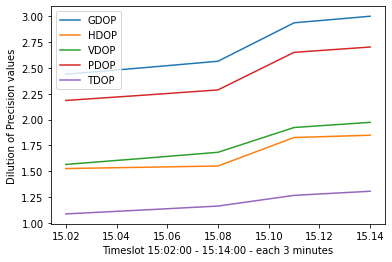

In [23]:
print(plot_time)
plt.plot(plot_count,GDOP_val, label="GDOP")
plt.plot(plot_count,HDOP_val, label="HDOP")
plt.plot(plot_count,VDOP_val, label="VDOP")
plt.plot(plot_count,PDOP_val, label="PDOP")
plt.plot(plot_count,TDOP_val, label="TDOP")
plt.legend()
plt.xlabel("Timeslot 15:02:00 - 15:14:00 - each 3 minutes")
plt.ylabel("Dilution of Precision values")
plt.show()

9.2


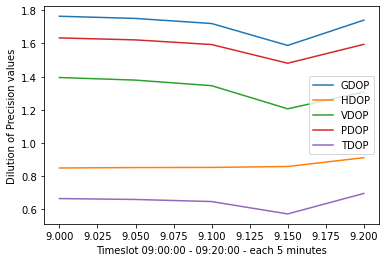

In [24]:
print(plot_time)
plt.plot(plot_count,GDOP_val, label="GDOP")
plt.plot(plot_count,HDOP_val, label="HDOP")
plt.plot(plot_count,VDOP_val, label="VDOP")
plt.plot(plot_count,PDOP_val, label="PDOP")
plt.plot(plot_count,TDOP_val, label="TDOP")
plt.legend()
plt.xlabel("Timeslot 09:00:00 - 09:20:00 - each 5 minutes")
plt.ylabel("Dilution of Precision values")
plt.show()

In [3]:
pc_boxes=read_ptcloud("D:/irina/Rezumate/delft/thesis/P3/data/pc/pc406.0.LAZ")
brd=[]
uncl=[]
grd=[]
for pt in pc_boxes:
    if(pt[3]==1.0):
        uncl.append(pt)
    elif(pt[3]==2.0):
        grd.append(pt)
    elif(pt[3]==26.0):
        brd.append(pt)

pc_cyl=read_ptcloud("D:/irina/Rezumate/delft/thesis/P3/data/cylinder/cylinder_406.0.LAZ")

In [36]:
#change the name of the point cloud if you want to see class analysis for another cylinder
pc_cyl=read_ptcloud("D:/irina/Rezumate/delft/thesis/P3/data/cylinder/cylinder_419.0.LAZ")
#cyl_pts=read_ptcloud(cyl_pc)
cls_ar=[]
cls_ar.append(pc_cyl[0][3])
#print(cls_ar)
no_pts_cls=[]
proc_cls=[]

for p in pc_cyl:
    if(p[3] not in cls_ar):
        cls_ar.append(p[3])
    # for j in cls_ar:
    #     if(j!=p[3]):
    #         cls_ar.append(p[3])

for c in cls_ar:
    no=0
    for p in pc_cyl:
        if(p[3]==c):
            no=no+1
    no_pts_cls.append(no)

for i in no_pts_cls:
    pr=(i/len(pc_cyl))*100
    proc_cls.append(pr)

print(cls_ar, proc_cls)


[26.0, 1.0, 2.0] [10.685377903920951, 89.30936613055819, 0.005255965520866183]


7480
6326
418
1856
5207
458
60729
4675
3092
11246
15926
192


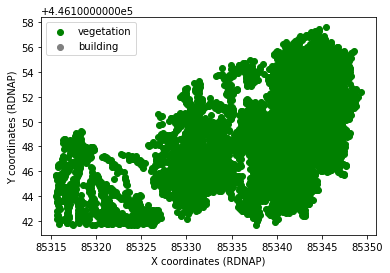

In [22]:
# plt.scatter(antenna_rdnap[0],antenna_rdnap[1],color='red')
# print(len(distr))
# print(len(distrib_satellites[0][10]))
# x=[]
# y=[]
# for dis in distrib_satellites[0][10]:

#     #if(dis[3]==)
#     x.append(dis[0])
#     y.append(dis[1])

# plt.scatter(x,y)
# plt.show()    
    

for dis in distrib_satellites[0]:
    print(len(dis))

veg_pts=[]
bld_pts=[]
for pcpt in distrib_satellites[0][0]:
    #print(pcpt)
    if (pcpt[3]==1.0):
        veg_pts.append(pcpt)

    if (pcpt[3]==6.0):
        bld_pts.append(pcpt)

xveg=[p[0] for p in veg_pts]
yveg=[p[1] for p in veg_pts]
xbld=[p[0] for p in bld_pts]
ybld=[p[1] for p in bld_pts]

plt.scatter(xveg,yveg,color="green",label="vegetation")
plt.scatter(xbld,ybld,color="grey",label="building")
plt.xlabel("X coordinates (RDNAP)")
plt.ylabel("Y coordinates (RDNAP)")
plt.legend()
plt.show()

        


    

In [4]:
from mpl_toolkits import mplot3d
%matplotlib ipympl

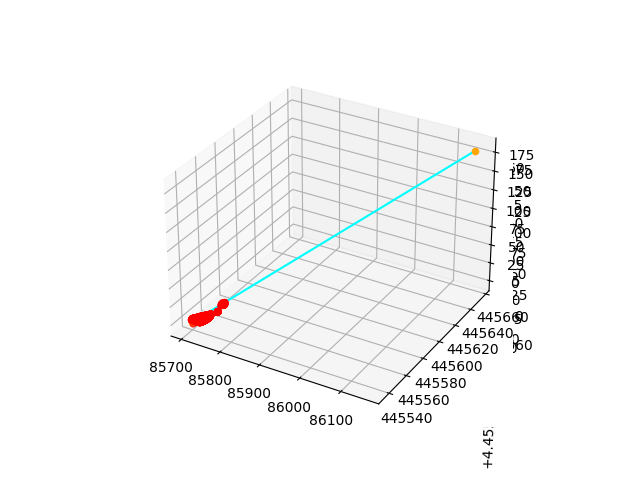

In [8]:
antenna_rdnap=[85706.24620461503, 445536.918930227, 0.5600000000000023]
satellite=[86157.41955145367, 445655.669084325, 180.2812036216215]
ax = plt.axes(projection='3d')
# ax.scatter3D(antenna_rdnap[0],antenna_rdnap[1],antenna_rdnap[2], color="yellow")
# ax.scatter3D(satellite[0],satellite[1],satellite[2],color="orange")
# ax.plot3D([antenna_rdnap[0],satellite[0]],[antenna_rdnap[1],satellite[1]],[antenna_rdnap[2],satellite[2]],color="cyan")

brd_x=[i[0] for i in brd]
brd_y=[i[1] for i in brd]
brd_z=[i[2] for i in brd]
uncl_x=[i[0] for i in uncl]
uncl_y=[i[1] for i in uncl]
uncl_z=[i[2] for i in uncl]
grd_x=[i[0] for i in grd]
grd_y=[i[1] for i in grd]
grd_z=[i[2] for i in grd]

cyl_x=[i[0] for i in pc_cyl]
cyl_y=[i[1] for i in pc_cyl]
cyl_z=[i[2] for i in pc_cyl]


# ax.scatter3D(uncl_x,uncl_y,uncl_z, color="purple")
# ax.scatter3D(grd_x,grd_y,grd_z,color="brown")
# ax.scatter3D(brd_x,brd_y,brd_z,color="grey")
ax.scatter3D(antenna_rdnap[0],antenna_rdnap[1],antenna_rdnap[2], color="yellow")
ax.scatter3D(satellite[0],satellite[1],satellite[2],color="orange")
ax.plot3D([antenna_rdnap[0],satellite[0]],[antenna_rdnap[1],satellite[1]],[antenna_rdnap[2],satellite[2]],color="cyan")
ax.scatter3D(cyl_x,cyl_y,cyl_z, color="red")

# ax.scatter3D(antenna_rdnap[0],antenna_rdnap[1],antenna_rdnap[2], color="red")

# satx=[s[0] for s in rdnap_plot]
# saty=[s[1] for s in rdnap_plot]
# satz=[s[2] for s in rdnap_plot]

# ax.scatter3D(satx,saty,satz, color="blue")

# for i in range(0,len(rdnap_plot)):
#     ax.plot3D([antenna_rdnap[0],rdnap_plot[i][0]],[antenna_rdnap[1],rdnap_plot[i][1]],[antenna_rdnap[2],rdnap_plot[i][2]], color="cyan")

plt.show()